In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from collections import Counter
import itertools

def flatten(listOfLists):
    "Flatten one level of nesting"
    return itertools.chain.from_iterable(listOfLists)

%matplotlib inline

# Why the 'AI revolution' is really a deep learning revolution

## Introduction

We often hear that there's been an explosion in AI research, that AI is advancing a breakneck speed.
However, when we look at computer science publications we see no evidence of such changes in the AI research landscape.
Infact many traditional fields such as logic programming, evolutionary algorithms, bayesian statistics appear to be on the decline.
What we do see is a unprecidented explosion of publications in the field of deep learning.
Since 2012 deep learning has gone from an unused term to a phrase that dominates the landscape.
We estimate that more than one fith of AI or similar publications are now part of a deep learning gold rush.
It is this explosion in deep learning that is fueling the latest media round of interest in AI.

## Dataset

arXiv is a free and open reposity for preprints of accademic papers that have been approved for publication after moderation. 

We take the titles of arXiv computer science publications tagged with any of the following catagories:

* AI - Artificial Intelligence
    * Covers all areas of AI except Vision, Robotics, Machine Learning, Multiagent Systems, and Computation and Language (Natural Language Processing), which have separate subject areas. In particular, includes Expert Systems, Theorem Proving (although this may overlap with Logic in Computer Science), Knowledge Representation, Planning, and Uncertainty in AI. 
* CL - Computation and Language (Computational Linguistics and Natural Language and Speech Processing)
    * Covers natural language processing. 
* CV - Computer Vision and Pattern Recognition
    * Covers image processing, computer vision, pattern recognition, and scene understanding.
* LG - Machine Learning
    * Covers machine learning and computational (PAC) learning. 
* NE - Neural and Evolutionary Computation
    * Covers neural networks, connectionism, genetic algorithms, artificial life, adaptive behavior. 

In [2]:
## uncomment and run the cell to download all of the data direct from arxiv (~1 hour)

# ! python scrape.py > data.jsonlines
# tags = ["cs.AI", "cs.CL", "cs.CV", "cs.LG", "cs.NE"]
# data = pd.read_json('./data.jsonlines', lines=True)
# data = data[data.catagories.apply(lambda records: any((item in records for item in tags)))]
# data['year'] = data['created'].str.split('-').apply(lambda x: int(x[0]))
# data = data[np.logical_and(data['year'] > 1996, data['year'] < 2018)]
# data.to_json('filtered.jsonlines', lines=True, orient='records')

In [3]:
# otherwise load the prefilted data from the repo
data = pd.read_json('./filtered.jsonlines', lines=True)[['title', 'year', 'catagories']]
data.head()

,title,year,catagories
0,Towards a human eye behavior model by applying...,2008,"[cs.HC, cs.NE]"
1,Eye-Tracking Evolutionary Algorithm to minimiz...,2008,[cs.AI]
2,Node discovery in a networked organization,2008,[cs.AI]
3,Robustness and Regularization of Support Vecto...,2008,"[cs.LG, cs.AI]"
4,Multiagent Approach for the Representation of ...,2008,[cs.AI]


In [4]:
len(data)

43244

## Preprocessing

Below we create columns in the dataset to mark the presence of some key words.

In [5]:
data['is_deep'] = data['title'].str.contains('deep', case=False)
data['is_adversarial'] = data['title'].str.contains('adversarial', case=False)
data['is_reinforcement'] = data['title'].str.contains('reinforcement', case=False)
data['is_convolutional'] = data['title'].str.contains('convolutional', case=False)
data['is_ai'] = data['title'].str.contains(' ai ', case=False)
data['is_artificial_intelligence'] = data['title'].str.contains('artificial intelligence', case=False)
data['is_logic'] = data['title'].str.contains('logic', case=False)
data['is_evolutionary'] = data['title'].str.contains('evolutionary', case=False)

## Results

### Word counts, in titles, per year

Fuzzy logic and logical programming were staples of AI research through the late ninties and early 21st century.
Below we can see a steady rate of publications containing the word `logic` in the title. 
There has been a gradual decline since 2002 as a share of the total number of publications.

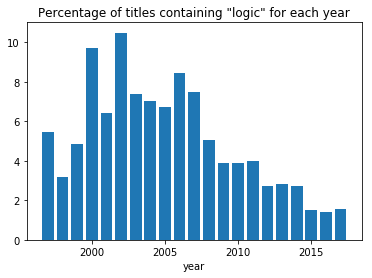

In [6]:
counts = {}
for year, group in data.groupby('year'):
    counts[year] = {'freq': sum(group['is_logic'] > 0), 'total': len(group)}
    
hist = []
years = sorted(counts.keys())    
for year in years:
    hist.append(100 * counts[year]['freq'] / counts[year]['total'])

plt.xlabel('year')
plt.title('Percentage of titles containing "logic" for each year')
plt.bar(years, hist)
plt.show()

Similarly evolutionary algorithms peaked around 2004 with a gradual rise and fall either side.

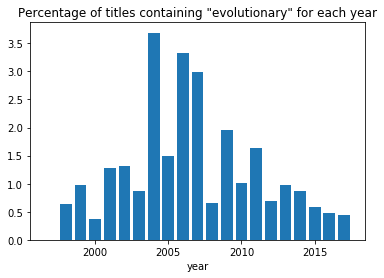

In [7]:
counts = {}
for year, group in data.groupby('year'):
    counts[year] = {'freq': sum(group['is_evolutionary'] > 0), 'total': len(group)}
    
hist = []
years = sorted(counts.keys())    
for year in years:
    hist.append(100 * counts[year]['freq'] / counts[year]['total'])

plt.xlabel('year')
plt.title('Percentage of titles containing "evolutionary" for each year')
plt.bar(years, hist)
plt.show()

In stark contrast with the previous two examples titles containing the word deep have exploded.

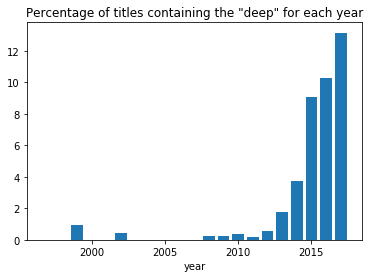

In [8]:
counts = {}
for year, group in data.groupby('year'):
    counts[year] = {
        'freq': sum(group['is_deep']),
        'total': len(group)
    }

hist = []
years = sorted(counts.keys())
for year in years:
    hist.append(100 * counts[year]['freq'] / counts[year]['total'])

plt.xlabel('year')
plt.title('Percentage of titles containing the "deep" for each year')

plt.bar(years, hist)
plt.show()

When we examine several words indicative of deep learning research such as `deep`, `adversarial` and `convolutional` we see what appears to be exponential growth from around 2012.

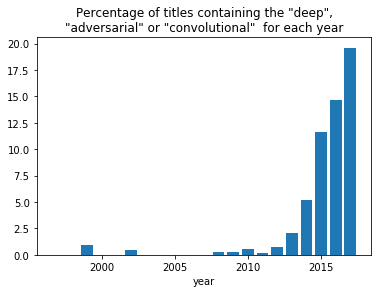

In [9]:
counts = {}
for year, group in data.groupby('year'):
    counts[year] = {
        'freq': sum(group['is_deep'] | group['is_adversarial'] | group['is_convolutional']),
        'total': len(group)
    }

hist = []
years = sorted(counts.keys())
for year in years:
    hist.append(100 * counts[year]['freq'] / counts[year]['total'])
    
plt.bar(years, hist)
plt.xlabel('year')
plt.title('Percentage of titles containing the "deep",\n"adversarial" or "convolutional"  for each year')
plt.show()

As a side note observe that the terms such as `artificial_intelligence` or `ai` are not commonly used in titles.
138 out of 41000 titles contain one of these terms (fewer than 0.5%)

In [15]:
len(data[data['is_artificial_intelligence'] | data['is_ai']]), len(data)

(138, 43244)

## Which words have changed?

Next we examine which words have seen the biggest increase or decreate in usage pre and post 2012

In [11]:
base_cv = CountVectorizer(analyzer='word', stop_words='english', ngram_range=[1, 2])
base_cv = base_cv.fit(data['title'])

cv = CountVectorizer(analyzer='word', stop_words='english', ngram_range=[1,2], vocabulary=base_cv.vocabulary_.keys())
arr = cv.fit_transform(data[data['year'] < 2012]['title'])
old_counts = np.array(np.sum(arr, axis=0)).flatten() / arr.shape[0]

cv = CountVectorizer(analyzer='word', stop_words='english', ngram_range=[1, 2], vocabulary=base_cv.vocabulary_.keys())
arr = cv.fit_transform(data[data['year'] > 2012]['title'])
new_counts = np.array(np.sum(arr, axis=0)).flatten()  / arr.shape[0]

In [12]:
diff = 100 * (new_counts - old_counts)
keys = list(base_cv.vocabulary_.keys())
arg_diff = np.argsort(diff)

### Pre - 2012

In [13]:
pd.DataFrame(
    [(keys[i], 100*old_counts[i], 100*new_counts[i], new_counts[i]/old_counts[i]) for i in arg_diff[:10]], 
    columns = ['word', 'old freq (%)', 'new freq (%)', 'ratio']
)

,word,old freq (%),new freq (%),ratio
0,logic,3.200746,0.809009,0.252756
1,systems,3.060907,1.478738,0.483104
2,programming,2.284027,0.820862,0.359393
3,algorithm,4.195152,2.735220,0.651995
4,information,3.076445,1.686176,0.548092
5,constraint,1.755749,0.435620,0.248111
6,algorithms,3.091983,1.834346,0.593259
7,theory,2.066501,0.811972,0.392921
8,language,3.262896,2.142540,0.656637
9,complexity,1.709136,0.663802,0.388385


### Post - 2012

In [14]:
pd.DataFrame(
    [(keys[i], 100*old_counts[i], 100*new_counts[i], new_counts[i]/old_counts[i]) for i in arg_diff[-10:]],
    columns = ['word', 'old freq (%)', 'new freq (%)', 'ratio']
)

/Users/dstaff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


,word,old freq (%),new freq (%),ratio
0,deep learning,0.000000,2.169210,inf
1,detection,2.377253,4.637724,1.950875
2,convolutional neural,0.000000,2.290710,inf
3,image,2.843381,5.746036,2.020846
4,neural networks,1.258546,4.868869,3.868647
5,convolutional,0.015538,3.834642,246.797570
6,neural,3.107520,9.313972,2.997236
7,networks,3.449347,9.767373,2.831658
8,learning,9.571162,17.632242,1.842226
9,deep,0.139838,8.946511,63.977491


Words such as:
* logic
* programming
* algorithms
* evolutionary

used to appear in between 1% and 5% or titles.
Their usage has generally been cut by a half or a third.

Words (and word pairs) such as:
* deep learning
* deep
* convolutional

have increased dramatically. In some cases they appear over 100 times more often than after 2012 compared to before 2012.

## Examining popular media

Let's compare the trends from arxiv to how the word AI is trending in guardian news articles. 
The trend is remarkably similar to the deep learning trend in accademic publications.

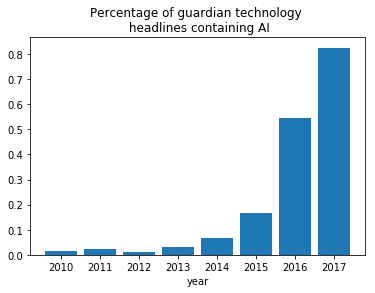

In [22]:
guardian_data = pd.DataFrame([  
   {'ai': 1, 'year': 2010, 'total': 7201},
   {'ai':2, 'year': 2011, 'total': 8117},
   {'ai':1, 'year': 2012, 'total': 8376},
   {'ai':3, 'year': 2013, 'total': 9874},
   {'ai':7, 'year': 2014, 'total': 10569},
   {'ai':16, 'year': 2015, 'total': 9535},
   {'ai':51, 'year': 2016, 'total': 9366},
   {'ai':60, 'year': 2017, 'total': 7272},
])

plt.bar(guardian_data['year'], 100 * guardian_data['ai'] / guardian_data['total'])
plt.xlabel('year')
plt.title('Percentage of guardian technology \n headlines containing AI')
plt.show()

# Conclusions

The computer science AI landscape has transformed since 2012.
Pre 2012 there were a braod range of topics such as `fuzzy logic`, `logic programming`, `evolutionary algorithms`.
There each had a presence in 1%-5% of publications.
Frequently domain specific algorithms were published that solve niche problems such as face detection or optimal searches.

Post 2012 the landscape has become much more monolithic with one topic, deep learning, dominating the landscape.
Deep learning has come from obscurity to ubiquity, the subject of approximately one in five publications whilst still growings in its share.
Following the incredibly rapid trends demonstated above deep learning is on course to saturate AI research in the next few years, although this is far from a certainty.

The data from the guardian strongly suggests that the increase in press overage of AI is being by breakthroughs in deep learning.

When reading about AI revolutions in the press we need to remember in reality it is a deep learning revolution.
Deep learning is not a silver bullet, while it will continue to make huge strides in some areas (very high dimensional proplems with huge datasets) it is unliekly to have any impact in others.

Deep leaning is applied to large datasets for high dimesnional problems such as image recognition, text to speach and translation. This is reflected in advances in products like Google Translate, Siri, Alexa and 

If we do not unsterstand the strengths and weeknesses of deep learning and communicate them to manage expectations we risk a damaging gap between expectation and reality, between researchers and technologists which could be harmful for future progress. 